In [0]:
!unzip -q '/content/drive/My Drive/train_val_test.zip' -d '/content'
import warnings
warnings.filterwarnings('always')

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical # może pozmieniać by wczytywał kieras przez tensorflow np from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from sklearn.metrics import classification_report

batch_size = 128 # było 64
epochs = 3
IMG_HEIGHT, IMG_WIDTH, channels = 220, 220, 3

dir = '/content/'
dir_path = os.path.join(dir, 'train_val_test')

train_gen = ImageDataGenerator(dtype='uint8') # rescale=1.0/255., dtype='uint8'
val_gen = ImageDataGenerator(dtype='uint8')
test_gen = ImageDataGenerator(dtype='uint8')

train_generator = train_gen.flow_from_directory(
    dir_path + '/train',
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=2)
validation_generator = val_gen.flow_from_directory(
    dir_path + '/val',
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=2)
test_generator = test_gen.flow_from_directory(
    dir_path + '/test',
    batch_size=1,
    shuffle=False,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=2)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarnin

Found 450265 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [3]:
model = Sequential()

# add model layers
model.add(Conv2D(32, kernel_size=3, activation="relu", 
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
                 data_format="channels_last"))
model.add(Conv2D(32, kernel_size=5, activation="relu"))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
# model.add(Dropout(0.3)) # użycie gdy jest przeuczony, dużo więcej acc niż val_acc
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=3, activation="relu"))
model.add(Conv2D(8, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
# warstwa łącząca conv2d z warstwą dense
model.add(Flatten())
# liczba taka ile wyjść, czyli 5 bo tyle jest typów
model.add(Dense(5, activation="softmax"))

# compile model using accuracy to measure model performance
model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              loss="categorical_crossentropy", metrics=["accuracy"])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
history = model.fit(train_generator, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, shuffle=True,
                    use_multiprocessing=True, verbose=1) # verbose=2 <- bez wskaznika postępu

Epoch 1/3
 - 3725s - loss: 0.6814 - accuracy: 0.7362 - val_loss: 0.5781 - val_accuracy: 0.7484
Epoch 2/3
 - 3740s - loss: 0.4370 - accuracy: 0.8322 - val_loss: 0.5916 - val_accuracy: 0.8280
Epoch 3/3
 - 3747s - loss: 0.3127 - accuracy: 0.8798 - val_loss: 0.5717 - val_accuracy: 0.8473


In [4]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size 
scores = model.evaluate_generator(generator=test_generator, 
                                  steps=STEP_SIZE_TEST,
                                  verbose=1)
print(model.metrics_names[0] + " = ", scores[0])
print(model.metrics_names[1] + " = ", scores[1])


test_generator.reset()
probabilities = model.predict_generator(generator=test_generator, 
                                        steps=STEP_SIZE_TEST,
                                        verbose=1)
y_test = probabilities.argmax(axis=1)
y_pred = test_generator.classes
print(classification_report(y_test, y_pred))

500/500 [==============================] - 5s 9ms/step
loss =  0.04507707431912422
accuracy =  0.8180000185966492
500/500 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        82
           1       0.80      0.63      0.70       127
           2       1.00      0.96      0.98       104
           3       0.72      0.77      0.75        93
           4       0.83      0.88      0.86        94

    accuracy                           0.82       500
   macro avg       0.82      0.83      0.82       500
weighted avg       0.82      0.82      0.82       500



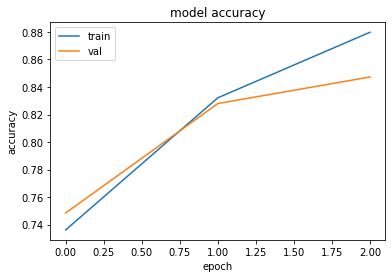

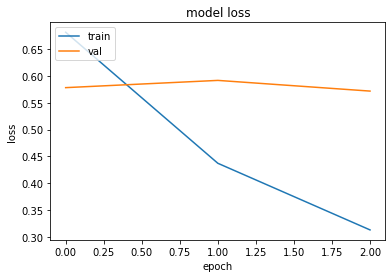

In [5]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:
# Zapisanie pliku .csv porównując typ i predykcję, jest podane zdjęcie więc łatwo będzie sprawdzić co z nim nie tak
test_generator.reset()
probabilities = model.predict_generator(test_generator, 
                                        steps=STEP_SIZE_TEST,
                                        verbose=1)
predicted_class_indices = np.argmax(probabilities, axis=1)
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results=pd.DataFrame({"Filename": filenames,
                      "Predictions": predictions,})
results.to_csv("results.csv", sep=';', index=False)

500/500 [==============================] - 3s 7ms/step


In [0]:
# Zapisanie modelu do pliku
model.save('wczytywanie_zdjec_model.h5')